In [1]:
import os
import glob
import pandas as pd
from pathlib import Path
from scipy import stats
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, cohen_kappa_score
import numpy as np
from hydra import initialize, compose
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import math
import os
import seaborn as sns

from sklearn import metrics, model_selection
from sklearn.preprocessing import scale, normalize
from sklearn import datasets, cluster
from sklearn import neighbors, ensemble, tree, linear_model
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

from hydra import initialize, compose

In [2]:
initialize('../data/raw_output/cross_val/checkpoints/CROSS_VAL_paper_v1_w_ES/2022-09-16_15:29:25.963345')

hydra.initialize()

In [3]:
cfg = compose(config_name='config.yaml')

In [4]:
def dataframe_preproc( df, columns=[] ):
    df.Prognosis.replace('SEVERE', 1, inplace=True)
    df.Prognosis.replace('MILD', 0, inplace=True)
    X_df = df.drop( columns=['ImageFile', 'Prognosis', 'Death'])    
    
    y = df[ ['Prognosis', 'Death'] ].values
        
    if len(columns) > 0:
        X_df = X_df[best_cols] # restrict to certain columns only
    
    X = X_df.values
    X_features = X_df.columns
        
    return X, y, X_features

def load_cv_data( cv=1, dataset='population_average', columns=[], include_death_column=False ):
    train_cv_df = pd.read_csv( cfg.datasets[dataset].cv_train_table+'cv'+str(cv)+'.csv')
    valid_cv_df = pd.read_csv( cfg.datasets[dataset].cv_valid_table+'cv'+str(cv)+'.csv')
    test_df = pd.read_csv(cfg.datasets[dataset].test_table)
    
    whole_test_df = pd.read_excel('/mnt/ncshare/ai4covid_hackathon/raw_data/completeTestClinData.xls')
    test_raw_df = whole_test_df[ ['ImageFile', 'Prognosis'] ]
    test_raw_df.Prognosis.replace('SEVERE', 1, inplace=True)
    test_raw_df.Prognosis.replace('MILD', 0, inplace=True)
    
    test_df.Prognosis = test_raw_df.Prognosis

    x_train, y_train, features_train = dataframe_preproc( train_cv_df, columns )
    x_valid, y_valid, features_valid = dataframe_preproc( valid_cv_df, columns )
    x_test, y_test, features_test = dataframe_preproc(test_df, columns)

    if include_death_column:
         return x_train, y_train, x_valid, y_valid, x_test, y_test
        
    else:
        # keep prognosis only
        y_train = y_train[:,0]
        y_valid = y_valid[:,0]
        y_test = y_test[:, 0]

        #print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
        return x_train, y_train, x_valid, y_valid, x_test, y_test
    
models_to_run = { 'Logistic': linear_model.LogisticRegression, 'XGB': XGBClassifier}

In [5]:
cross_val_predictions = {model_name: { fold: [] for fold in range(1, 6)} for model_name in models_to_run.keys()}

for model_name, model in models_to_run.items():
    print(f'Cross-validating the {model_name} model')
    print('Fold:\t', end='')
    for fold in range(1,6):
        model_instance = model(n_jobs=8) if model_name == "Logistic" else model(n_jobs=8, eval_metric='error')
        print(f'{fold}', end=',   ')
        x_train, y_train, x_valid, y_valid, x_test, y_test = load_cv_data(fold, 'population_average', [])
        model_instance.fit(x_train, y_train)
        pred_values_label = model_instance.predict(x_valid)
        cross_val_predictions[model_name][fold] = model_instance.predict(x_valid).tolist()
    print('')

Cross-validating the Logistic model
Fold:	1,   2,   3,   4,   5,   
Cross-validating the XGB model
Fold:	1,   2,   3,   4,   5,   


In [6]:
from utils import ConfusionMatrixDisplay
import matplotlib

font = {'size'   : 30}

matplotlib.rc('font', **font)

def run_cv_analysis(base_path, cross_val_predictions):
    paths = list(filter(lambda x: x is not None, [path if path.is_dir() else None for path in\
         Path(base_path).iterdir()]))

    file = pd.read_csv(paths[0] / 'pred_valid.csv').file

    cols = ["file"]
    cols.extend([f"nn_prognosis_{ind + 1}" for ind in range(len(list(paths)))])
    preds = pd.DataFrame(columns=cols)

    preds["file"] = file

    for _, path_dir in enumerate(paths):
        try:
            fold = int(open(os.path.join(path_dir, "fold"), "r").readline()) + 1

            pred = pd.read_csv(path_dir / 'pred_valid.csv')
            preds[f"nn_prognosis_{fold}"] = pred.prognosis
            preds[f"nn_prognosis_{fold}"].replace('SEVERE', 1, inplace=True)
            preds[f"nn_prognosis_{fold}"].replace('MILD', 0, inplace=True)
            
            preds[f"prognosis_{fold}_real"] = pred["prognosis_real"]
            preds[f"prognosis_{fold}_real"].replace('SEVERE', 1, inplace=True)
            preds[f"prognosis_{fold}_real"].replace('MILD', 0, inplace=True)
            
            for model, folds in cross_val_predictions.items():
                preds[f"{model.lower()}_prognosis_{fold}"] = folds[fold]
            
        except Exception:
            print('?')
            continue
    
    return preds

In [7]:
progs = run_cv_analysis('../data/raw_output/cross_val/checkpoints_image_only/', cross_val_predictions)

In [8]:
progs.head()

,file,nn_prognosis_1,nn_prognosis_2,nn_prognosis_3,nn_prognosis_4,nn_prognosis_5,prognosis_1_real,logistic_prognosis_1,xgb_prognosis_1,prognosis_4_real,...,xgb_prognosis_4,prognosis_5_real,logistic_prognosis_5,xgb_prognosis_5,prognosis_2_real,logistic_prognosis_2,xgb_prognosis_2,prognosis_3_real,logistic_prognosis_3,xgb_prognosis_3
0,P_2_70.png,1,0,0,1,1,0,0,1,1,...,1,1,1,1,0,1,0,0,0,0
1,P_1_54.png,1,0,1,1,0,1,1,1,0,...,0,1,0,1,1,0,0,1,1,1
2,P_827.png,1,0,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,1
3,P_570.png,0,1,0,1,1,1,0,1,1,...,1,0,0,0,1,1,1,0,0,0
4,P_504.png,1,0,1,1,1,0,0,0,0,...,1,1,1,1,0,0,0,1,1,1


In [16]:
def run_analysis(progs):
    cf_matrices = {"nn_xgb": [], "nn_log": [], "xgb_log": []}

    for fold in range(1, 6):
        #print('FOLD:', fold)
        nn = progs[f"nn_prognosis_{fold}"].values
        logistic = progs[f"logistic_prognosis_{fold}"].values
        xgb = progs[f"xgb_prognosis_{fold}"].values
        true = progs[f"prognosis_{fold}_real"].values

        indicies_logistic_and_true_match = set(np.nonzero(np.ones_like(true) - true - logistic)[0].tolist())
        indicies_xgb_and_true_match = set(np.nonzero(np.ones_like(true) - true - xgb)[0].tolist())
        indicies_nn_and_true_match = set(np.nonzero(np.ones_like(true) - true - nn)[0].tolist())

        indicies_nn_and_logistic_match = set(np.nonzero(np.ones_like(nn) - nn - logistic)[0].tolist())
        indicies_nn_and_xgb_match = set(np.nonzero(np.ones_like(nn) - nn - xgb)[0].tolist())
        indicies_logistic_and_xgb_match = set(np.nonzero(np.ones_like(logistic) - logistic - xgb)[0].tolist())

        #print('NN overlap with TRUE', len(indicies_nn_and_true_match)/len(true))
        #print('LOGISTIC overlap with TRUE', len(indicies_logistic_and_true_match)/len(true))
        #print('XGB overlap with TRUE', len(indicies_xgb_and_true_match)/len(true))
        #print('XGB overlap with NN', len(indicies_nn_and_xgb_match)/ len(true))
        #print('LOGISTIC overlap with NN', len(indicies_nn_and_logistic_match)/ len(true))
        #print('LOGISTIC overlap with XGB', len(indicies_logistic_and_xgb_match)/len(true))

        nn_matches_true = np.abs(np.ones_like(true) - true - nn)
        xgb_matches_true = np.abs(np.ones_like(true) - true - xgb)
        logistic_matches_true = np.abs(np.ones_like(true) - true - logistic)

        nn_xgb = confusion_matrix(xgb_matches_true, nn_matches_true, normalize='all')
        nn_logistic = confusion_matrix(logistic_matches_true, nn_matches_true, normalize='all')
        xgb_logistic = confusion_matrix(logistic_matches_true, xgb_matches_true, normalize='all')

        cf_matrices["nn_xgb"].append(nn_xgb)
        cf_matrices["nn_log"].append(nn_logistic)
        cf_matrices["xgb_log"].append(xgb_logistic)

    fig, axes = plt.subplots(1, 3, figsize=(40, 10))
    disp = ConfusionMatrixDisplay(np.mean(cf_matrices["nn_xgb"], axis=0),
                                  display_labels=['0', '1'], xlabel='$NN_{precision}$ matches GT',
                                  ylabel='XGBoost matches GT')
    disp.plot(values_format='.3f', ax=axes[0], cmap="Greens", include_values=True)
    kappa = cohen_kappa_score(nn, xgb)
    axes[0].set_title(f'a) $\kappa$={kappa:.3f}', fontsize=40)

    disp = ConfusionMatrixDisplay(np.mean(cf_matrices["nn_log"], axis=0),
                                  display_labels=['0', '1'], xlabel='$NN_{precision}$ matches GT',
                                  ylabel='Logistic matches GT')
    disp.plot(values_format='.3f', ax=axes[1], cmap="Greens", include_values=True)
    kappa = cohen_kappa_score(nn, logistic)
    axes[1].set_title(f'b) $\kappa$={kappa:.3f}', fontsize=40)

    disp = ConfusionMatrixDisplay(np.mean(cf_matrices["xgb_log"], axis=0), 
                                  display_labels=['0', '1'], xlabel='XGBoost matches GT',
                                  ylabel='Logistic matches GT')
    disp.plot(values_format='.3f', ax=axes[2], cmap="Greens", include_values=True)
    kappa = cohen_kappa_score(xgb, logistic)
    axes[2].set_title(f'c) $\kappa$={kappa:.3f}', fontsize=40)
    
    plt.show()

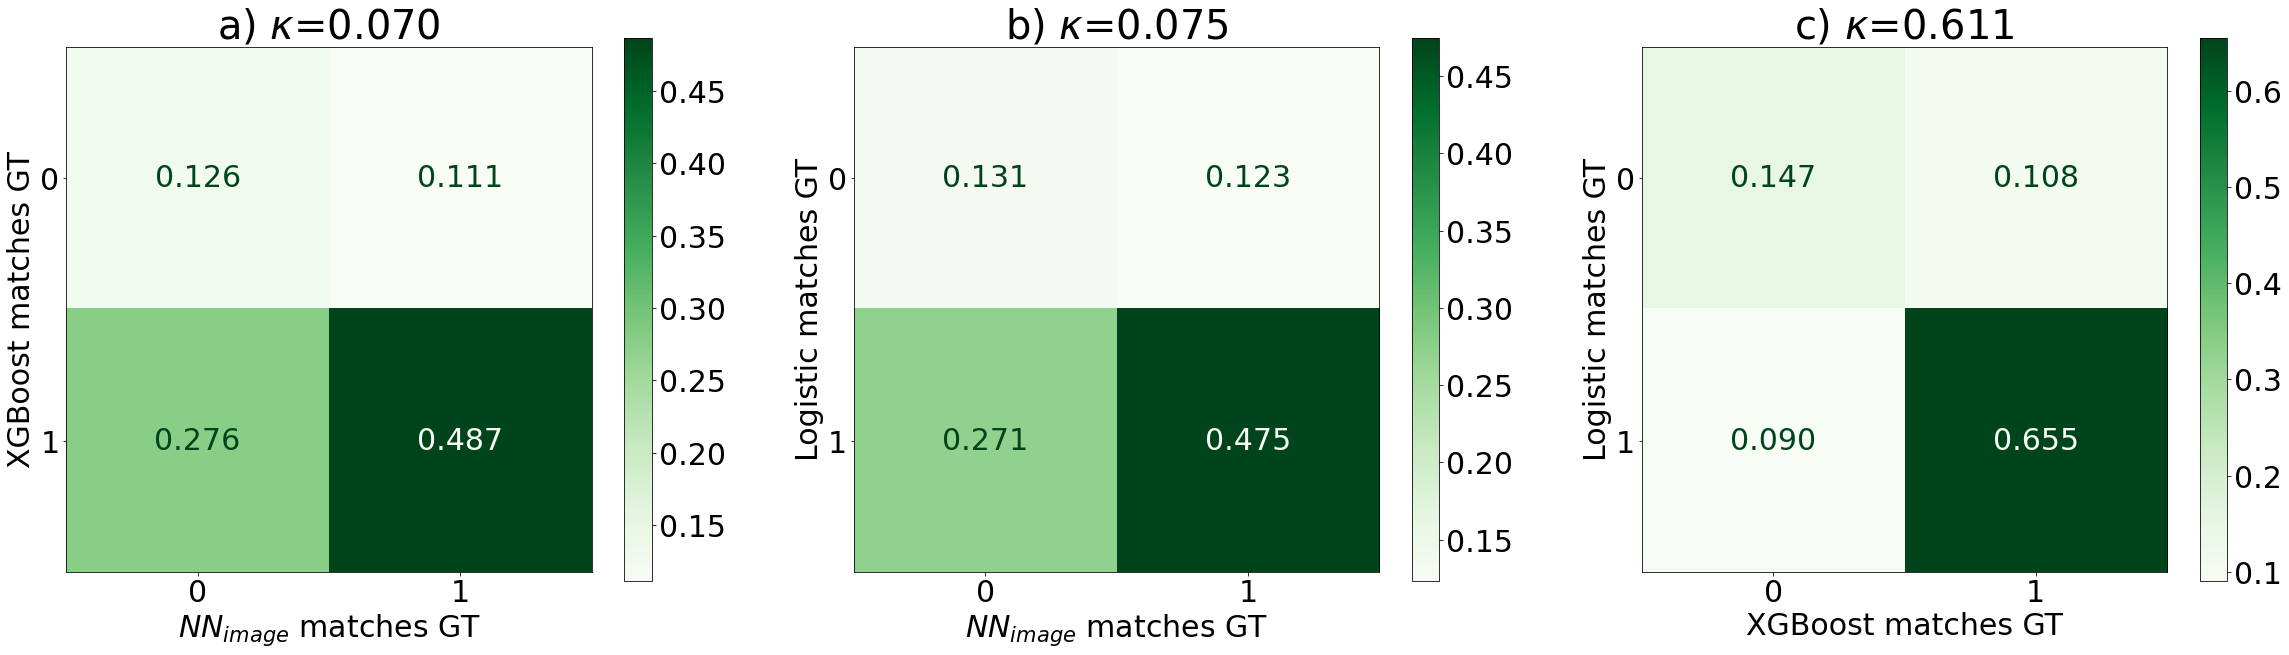

In [15]:
run_analysis(run_cv_analysis('../data/raw_output/cross_val/checkpoints_image_only/', cross_val_predictions))

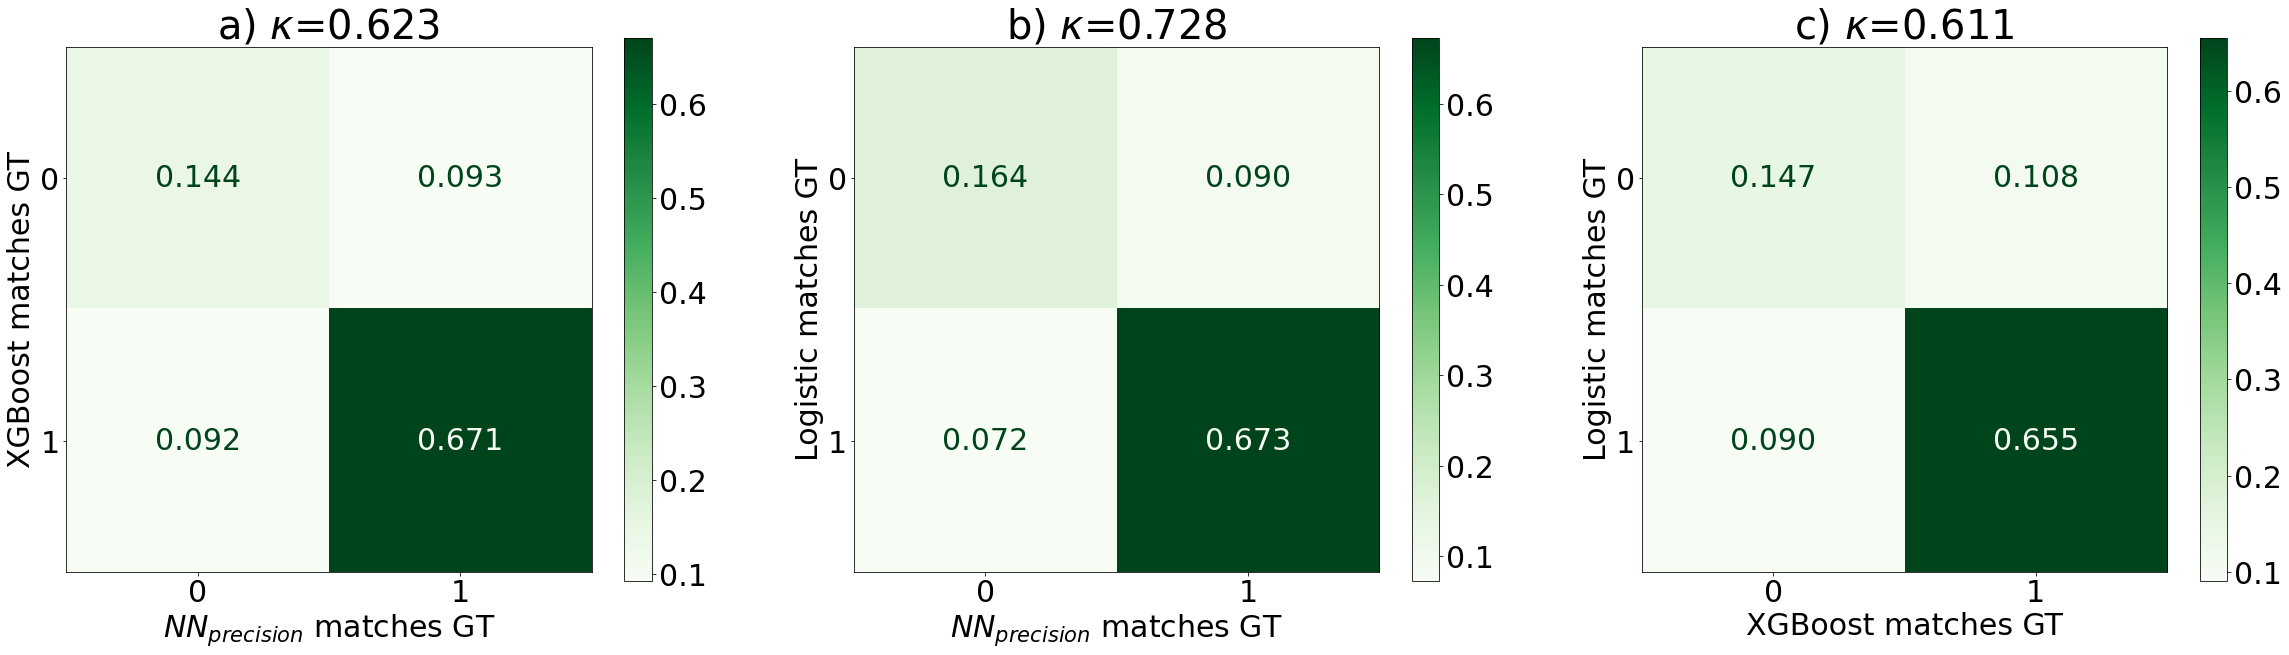

In [17]:
run_analysis(run_cv_analysis('../data/raw_output/cross_val/checkpoints/CROSS_VAL_paper_v1_w_ES/',
                             cross_val_predictions))